### VAR

- 분산-공분산 기법은 관측 값이 정규분포를 따른다고 가정하므로 모수적 방법이라고 한다.

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import yfinance as yf
from scipy.stats import norm
import requests
from io import StringIO
import seaborn as sns; sns.set()
import warnings
import json
import os
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

- 단일 자산으로 구성된 포트폴리오가 있다고 가정한다.
- 이 자산의 수익률은 0이고 표준편차는 1이며 보유 기간이 1일 경우, 해당하는 Z 값과 표준편차에 의해 자산 가치로부터 해당 VaR을 계산할 수 있다.
- 하지만 자산 수익이 정규분포를 따른다는 보장이 없기 때문에 매우 강력한 가정이다. 오히려 대부분의 자산 수익률은 정규분포를 따르지 않는다.
- 또한 정규성 가정으로 인해 꼬리 부분의 잠재적 위험이 포착되지 않을 수 있따.

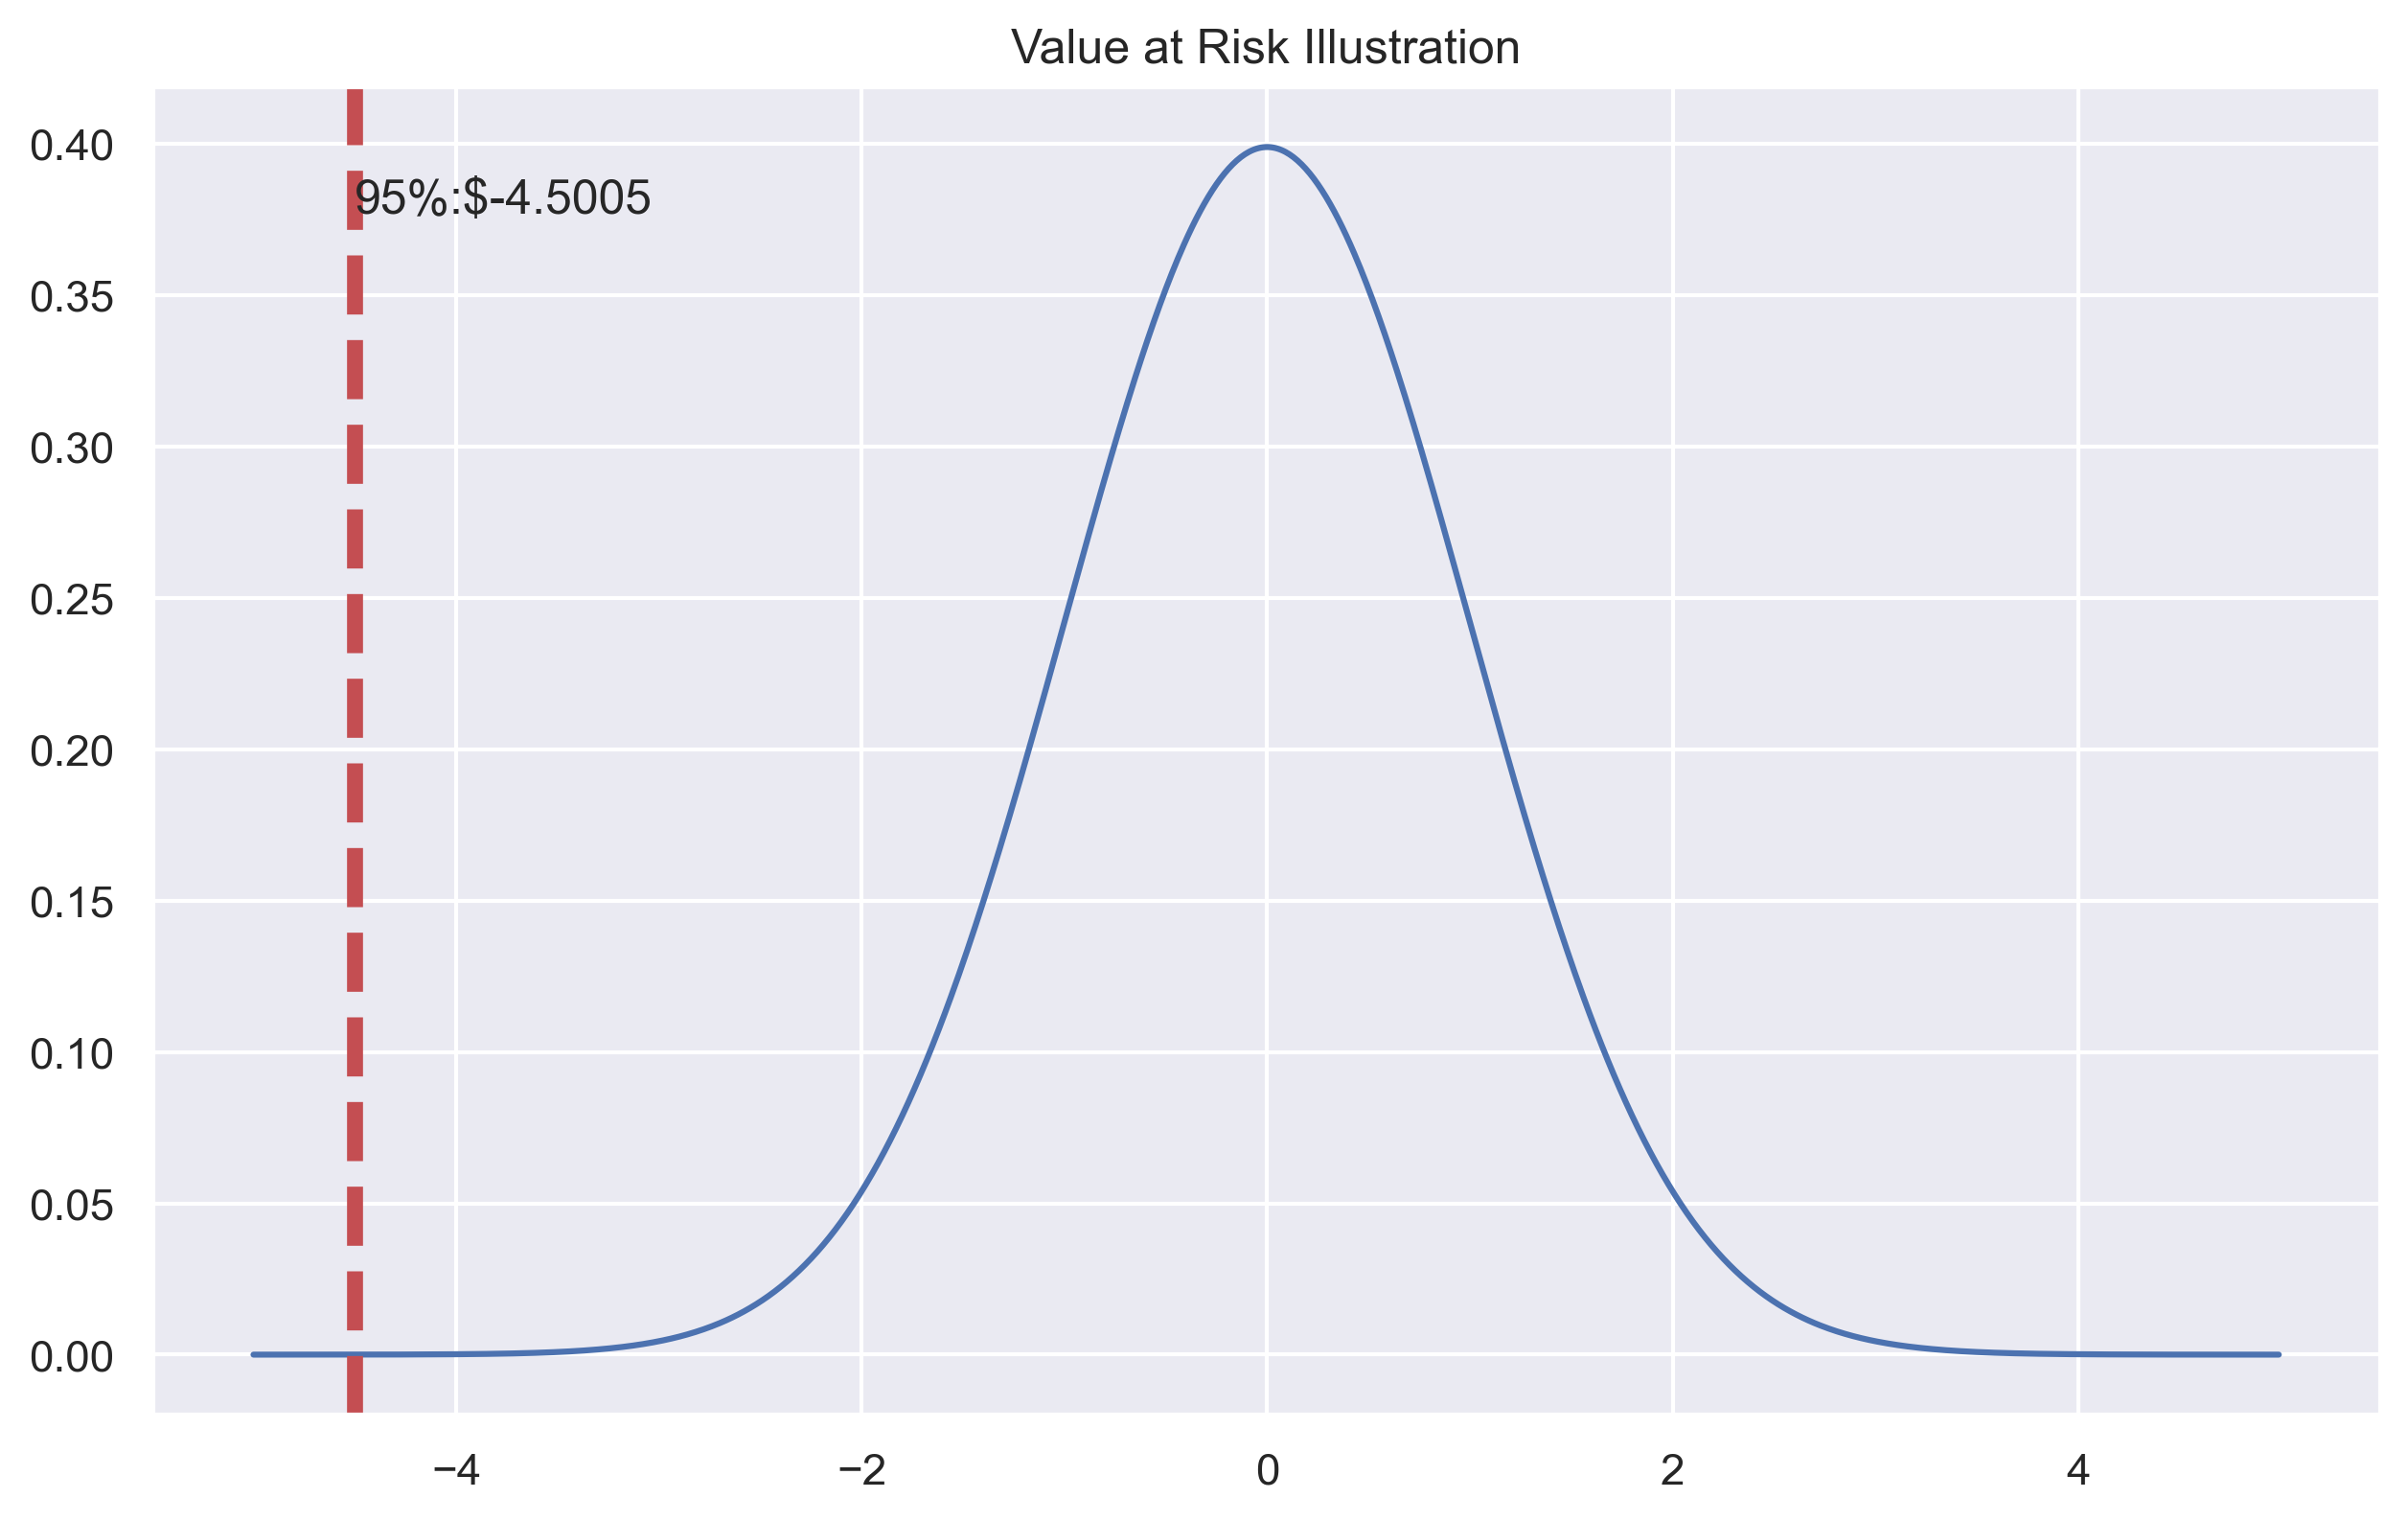

In [22]:
mean = 0
std_dev = 1
x = np.arange(-5, 5, 0.01)
y = norm.pdf(x, mean, std_dev) #주어진 x, 평균, 표준편차를 기반으로 확률 밀도 함수 생성
pdf = plt.plot(x, y)
min_ylim, max_ylim = plt.ylim()
plt.text(np.percentile(x, 5), max_ylim * 0.9, '95%:${:.4f}'
         .format(np.percentile(x, 5))) # x 데이터의 5% 백분위수에서 x의 위치 지정
plt.axvline(np.percentile(x, 5), color='r', linestyle='dashed',
            linewidth=4)
plt.title('Value at Risk Illustration')
plt.show()

In [65]:
API_KEY = os.environ.get('alpha_vantage_key')

def getDailyData(symbol) -> json:
        parameters = {'function': 'TIME_SERIES_DAILY', 
                      'symbol': symbol,
                       # 'outputsize':'full',
                       # 'datatype': 'csv', 
                       'apikey': API_KEY} 

        response = requests.get('https://www.alphavantage.co/query',
                                params=parameters)

        data = json.loads(response.text)
        return data
        # csvText = StringIO(response.text)
        # json.loads(data)
        # return data


# def getDailyData(symbol):
#     parameters = {
#         'function': 'TIME_SERIES_DAILY',
#         'symbol': symbol,
#         'apikey': 'YOUR_API_KEY',  # Replace with your actual API key
#     }
#     response = requests.get('https://www.alphavantage.co/query', params=parameters)
    
#     # Check for errors in the API response
#     if 'Error Message' in response.text:
#         raise ValueError(f"API Error: {response.text}")
    
#     csvText = StringIO(response.text)
    
#     # Print or log the received data
#     data = pd.read_csv(csvText, index_col='timestamp')
#     print(data.head())  # or use logging.info(data.head()) for logging
    
#     return data


In [34]:
data=getDailyData("MSFT")

In [51]:
import json
data = json.loads(data)

In [61]:
data.get("Meta Data")

{'1. Information': 'Daily Prices (open, high, low, close) and Volumes',
 '2. Symbol': 'MSFT',
 '3. Last Refreshed': '2023-12-08',
 '4. Output Size': 'Compact',
 '5. Time Zone': 'US/Eastern'}

In [90]:
stock = pd.DataFrame(data.get("Time Series (Daily)")).T["4. close"]
stock.index = pd.to_datetime(df.index)
stock = df.sort_index()

In [91]:
df

2023-07-20    346.8700
2023-07-21    343.7700
2023-07-24    345.1100
2023-07-25    350.9800
2023-07-26    337.7700
                ...   
2023-12-04    369.1400
2023-12-05    372.5200
2023-12-06    368.8000
2023-12-07    370.9500
2023-12-08    374.2300
Name: 4. close, Length: 100, dtype: object

In [119]:
symbols = ["IBM", "MSFT", "INTC"]
stock3 = []
for symbol in symbols:
    stock = pd.DataFrame(data.get("Time Series (Daily)")).T["4. close"]
    stock.index = pd.to_datetime(df.index)
    stock3.append(df.sort_index())
stocks = pd.concat(stock3, axis=1).astype("float")
stocks.columns = symbols

## Variance-Covariance Method

In [122]:
stocks_returns = (np.log(stocks) - np.log(stocks.shift(1))).dropna() #로그 수익률 계산
stocks_returns

,IBM,MSFT,INTC
2023-07-21,-0.008977,-0.008977,-0.008977
2023-07-24,0.003890,0.003890,0.003890
2023-07-25,0.016866,0.016866,0.016866
2023-07-26,-0.038364,-0.038364,-0.038364
2023-07-27,-0.021093,-0.021093,-0.021093
...,...,...,...
2023-12-04,-0.014443,-0.014443,-0.014443
2023-12-05,0.009115,0.009115,0.009115
2023-12-06,-0.010036,-0.010036,-0.010036
2023-12-07,0.005813,0.005813,0.005813


In [123]:
stocks_returns_mean = stocks_returns.mean()
weights  = np.random.random(len(stocks_returns.columns)) #가중치로 사용할 난수 추출
weights /= np.sum(weights) #가중치 생성
cov_var = stocks_returns.cov() #공분산 행렬 계산
port_std = np.sqrt(weights.T.dot(cov_var).dot(weights)) #포트폴리오 표준편차 찾기

In [124]:
initial_investment = 1e6
conf_level = 0.95

In [125]:
def VaR_parametric(initial_investment, conf_level):
    alpha = norm.ppf(1 - conf_level, stocks_returns_mean, port_std) #퍼센트 포인트 함수(ppf)를 사용해 특정 값에 대한 Z-점수 계산
    for i, j in zip(stocks.columns, range(len(stocks.columns))):
        VaR_param = (initial_investment - initial_investment * 
                     (1 + alpha))[j]  #분산-공분산 VaR 모델 추정
        print("Parametric VaR result for {} is {} "
              .format(i, VaR_param))
    VaR_param = (initial_investment - initial_investment * (1 + alpha))
    print('--' * 25)
    return VaR_param

In [126]:
VaR_param = VaR_parametric(initial_investment, conf_level)
VaR_param

Parametric VaR result for IBM is 21607.891300894902 
Parametric VaR result for MSFT is 21607.891300894902 
Parametric VaR result for INTC is 21607.891300894902 
--------------------------------------------------


array([21607.89130089, 21607.89130089, 21607.89130089])

- VaR은 보유 기간에 따라 sqrt(t)에 비례해 커진다. 
- 또한 보유기간은 포트폴리오 청산 중 가장 긴 기간이다.
- 보고 목적을 고려할 때 투자자에게는 0일이 더 적합할수 있다.

#### 분산-공분산 방법의 장단점
- 장점
    - 계산이 용이하다.
    - 많은 수의 샘플이 필요하지 않다.
- 단점
    - 관찰은 정규분포를 따른다.
    - 비선형 구조에서는 잘 작동하지 않다.
    - 공분산 행렬의 계산이 필요하다.
 
- 정규성을 가정하는 것은 자산 수익률이 정규분포를 갖지 않는 경우 VaR을 추정하는 가장 좋은 방법이 아닐 수 있다.
- 정규성 가정이 없는 방법으로는 과거 시뮬레이션 VaR모델이 있다.

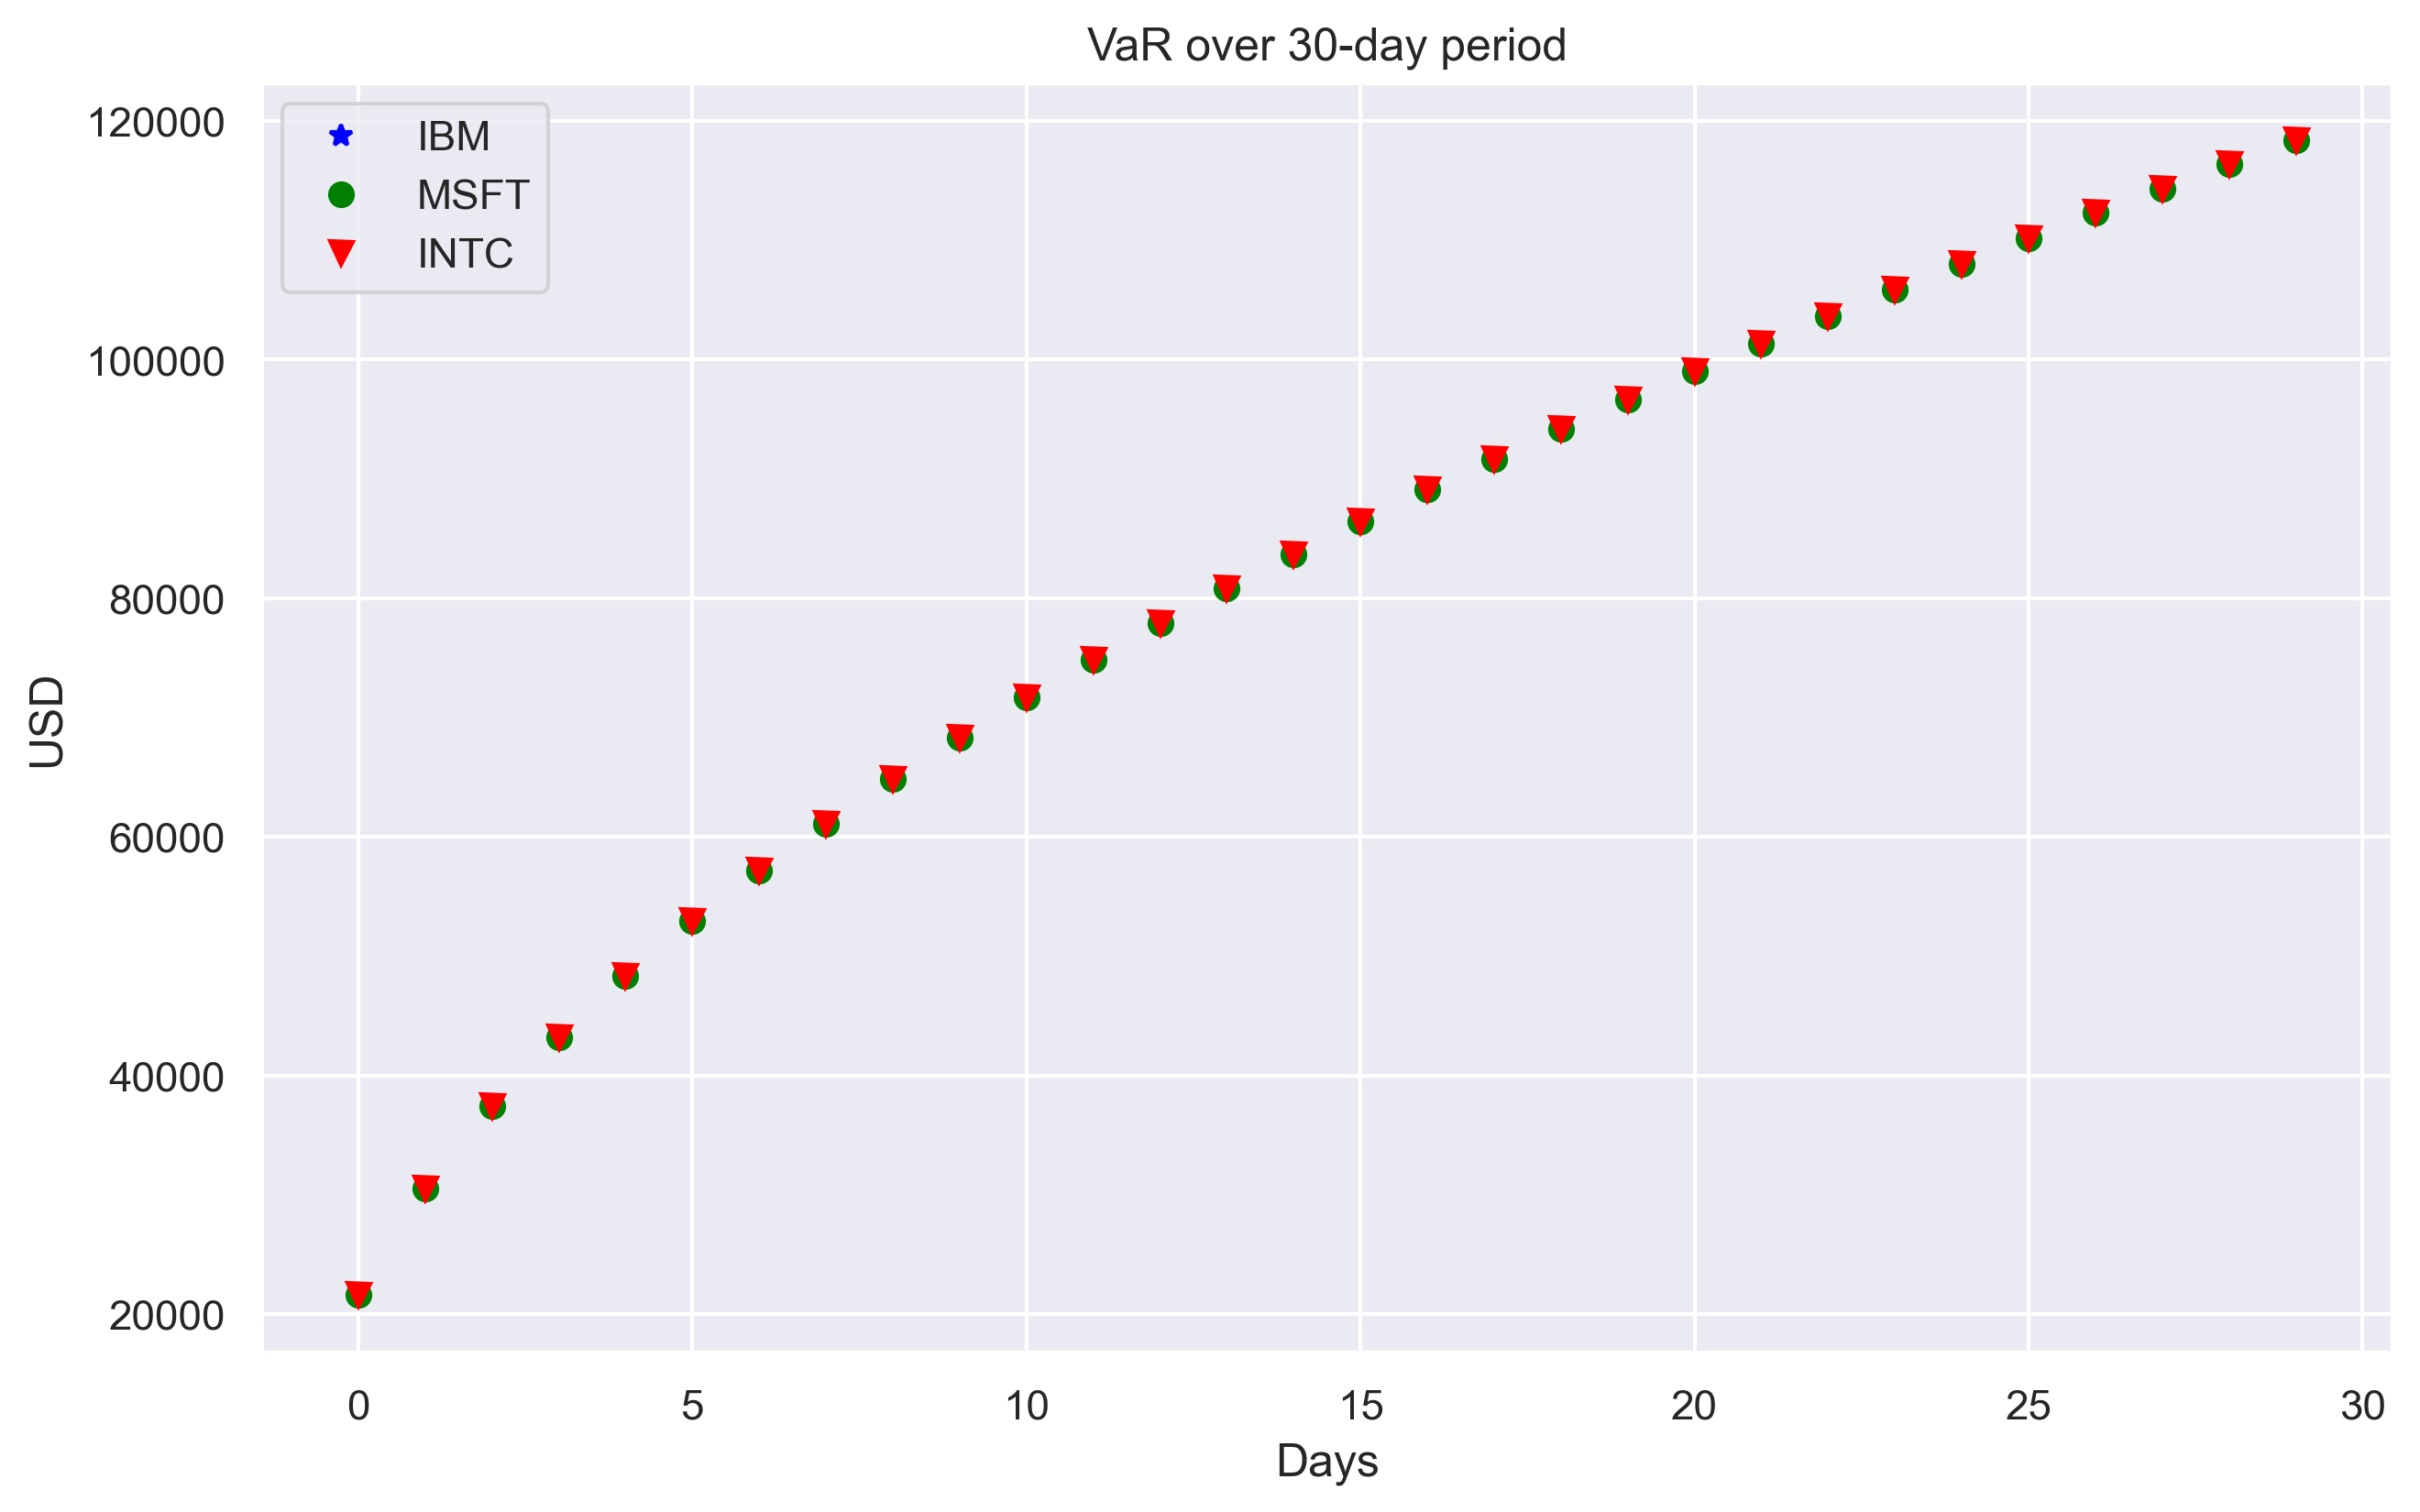

In [127]:
var_horizon = []
time_horizon = 30
for j in range(len(stocks_returns.columns)):
    for i in range(1, time_horizon + 1):
        var_horizon.append(VaR_param[j] * np.sqrt(i))
plt.plot(var_horizon[:time_horizon], "o",
         c='blue', marker='*', label='IBM')
plt.plot(var_horizon[time_horizon:time_horizon + 30], "o",
         c='green', marker='o', label='MSFT')
plt.plot(var_horizon[time_horizon + 30:time_horizon + 60], "o",
         c='red', marker='v', label='INTC')
plt.xlabel("Days")
plt.ylabel("USD")
plt.title("VaR over 30-day period")
plt.legend()
plt.show()

## Historical Simulation VaR

- 과거 시뮬레이션 VaR를 사용하는 단계
    - 포트폴리오의 자산 수익률 획득
    - 신뢰구간을 기반으로 해당 수익 백분위수를 찾는다
    - 이 분위수에 초기 투자를 곱한다.

In [128]:
def VaR_historical(initial_investment, conf_level):
    Hist_percentile95 = []
    for i, j in zip(stocks_returns.columns,
                    range(len(stocks_returns.columns))):
        Hist_percentile95.append(np.percentile(stocks_returns.loc[:, i],
                                               5))
        print("Based on historical values 95% of {}'s return is {:.4f}"
              .format(i, Hist_percentile95[j]))
        VaR_historical = (initial_investment - initial_investment *
                          (1 + Hist_percentile95[j]))
        print("Historical VaR result for {} is {:.2f} "
              .format(i, VaR_historical))
        print('--' * 35)

In [129]:
VaR_historical(initial_investment,conf_level)

Based on historical values 95% of IBM's return is -0.0244
Historical VaR result for IBM is 24377.67 
----------------------------------------------------------------------
Based on historical values 95% of MSFT's return is -0.0244
Historical VaR result for MSFT is 24377.67 
----------------------------------------------------------------------
Based on historical values 95% of INTC's return is -0.0244
Historical VaR result for INTC is 24377.67 
----------------------------------------------------------------------


#### 역사적 시뮬레이션 VaR 방법은 역사적 가격 변동이 유사한 패턴, 즉 구조적 변화(structural break)가 없다고 암시적으로 가정한다.

- 장점
    - 분포에 대한 가정이 없다.
    - 비선형 구조에서 잘 작동한다.
    - 계산하기 쉽다.
- 단점
    - 많은 샘플이 필요하다.
    - 높은 연산 성능이 필요하다.

## Monte Carlo VaR

- 몬테 카를로는 닫힌 형식의 해가 없는 경우 추정을 수행하는 데 사용되는 수학적 방법으로 수치 근사를 위한 도구이다.
- 몬테 카를로는 주어진 분포에서 반복되는 무작위 표본에 의존한다.
- 역사적 시뮬레이션 VaR와 유사하지만, 역사적 관찰을 사용하지 않는다.
- 주어진 분포에서 무작위 샘플을 생성한다.
- 가능한 결과와 확률 간의 연결을 제공해 의사결정자를 돕는다.

```
몬테 카를로 방법은 확률과 용량 사이의 유추를 기반으로 한다. 
측정의 수학은 확률의 직관적인 개념을 공식화해 사건을 일련의 결과와 연결하고 사건의 확률을 가능한 결과의 우주에 대한 용량 또는 측정값으로 정의한다.
몬테 카를로는 이 항등식을 역으로 사용해 용량을 확률로 해석해 집합의 용량을 계산한다.
```

In [130]:
x = np.random.uniform(-1, 1, 100) # 균등 분포에서 난수 생성
y = np.random.uniform(-1, 1, 100)

In [131]:
sample = 100    
def pi_calc(x, y):
    point_inside_circle = 0
    for i in range(sample):
        if np.sqrt(x[i] ** 2 + y[i] ** 2) <= 1: #반지름이 1인 원 안에 점이 있는지 확인
            point_inside_circle += 1 
    print('pi value is {}'.format(4 * point_inside_circle/sample))

In [132]:
pi_calc(x,y)

pi value is 3.4


In [133]:
x = np.random.uniform(-1, 1, 1000000)
y = np.random.uniform(-1, 1, 1000000)

In [134]:
sample = 1000000   

def pi_calc(x, y):
    point_inside_circle = 0
    for i in range(sample):
        if np.sqrt(x[i] ** 2 + y[i] ** 2) < 1:
            point_inside_circle += 1 
    print('pi value is {:.2f}'.format(4 * point_inside_circle/sample))

In [135]:
pi_calc(x,y)

pi value is 3.14


In [136]:
sim_data = pd.DataFrame([])
num_reps = 1000
n = 100
for i in range(len(stocks.columns)):
    mean = np.random.randn(n).mean()
    std = np.random.randn(n).std()
    temp = pd.DataFrame(np.random.normal(mean, std, num_reps))
    sim_data = pd.concat([sim_data, temp], axis=1)
sim_data.columns = ['Simulation 1', 'Simulation 2', 'Simulation 3']

In [137]:
sim_data

,Simulation 1,Simulation 2,Simulation 3
0,0.196919,2.119036,-0.052466
1,-0.893063,0.998095,-0.424607
2,-2.671583,2.240698,-0.585355
3,0.923635,0.219771,-1.793330
4,0.058059,2.425666,-0.274430
...,...,...,...
995,2.414801,-0.858542,-0.403707
996,0.587635,-0.450403,-0.960449
997,-0.372829,-0.293450,-2.640329
998,0.596176,0.652938,-2.151769


In [138]:
def MC_VaR(initial_investment, conf_level):
    MC_percentile95 = []
    for i, j in zip(sim_data.columns, range(len(sim_data.columns))):
        MC_percentile95.append(np.percentile(sim_data.loc[:, i], 5))  #모든 주식 수익률의 95%를 계싼하고 MC_percentile95라는 리스트에 결과를 추가한다.
        print("Based on simulation 95% of {}'s return is {:.4f}"
              .format(i, MC_percentile95[j]))
        VaR_MC = (initial_investment - initial_investment * 
                  (1 + MC_percentile95[j]))  #몬테 카를로 VaR 추정
        print("Simulation VaR result for {} is {:.2f} "
              .format(i, VaR_MC))
        print('--' * 35)

In [139]:
MC_VaR(initial_investment, conf_level)

Based on simulation 95% of Simulation 1's return is -2.2416
Simulation VaR result for Simulation 1 is 2241575.85 
----------------------------------------------------------------------
Based on simulation 95% of Simulation 2's return is -1.8501
Simulation VaR result for Simulation 2 is 1850101.52 
----------------------------------------------------------------------
Based on simulation 95% of Simulation 3's return is -1.7197
Simulation VaR result for Simulation 3 is 1719690.24 
----------------------------------------------------------------------


## 잡음 제거
- 일반적으로 시장에는 잡음과 신호라는 두 가지 유형의 정보가 있다.
- 전자는 무작위 정보만 생성하지만 후자는 투자자가 돈을 벌 수 있는 귀중한 정보를 제공한다.

### The Marcenko-Pastur Theory
- 마르첸코 - 파스퇴르 정리를 통해 공분산 행렬의 고윳값을 사용해 잡음에서 신호를 추출할 수 있다.
- 고윳값과 고유 벡터는 재정적 맥락에서 특별한 의미를 가진다.
- 고유 벡터는 공분산 행렬의 분산을 나타내는 반면, 고윳값은 고유 벡터의 크기를 나타낸다.
- 가장 큰 고유 벡터는 가장 큰 분산에 해당하며, 그 크기는 해당 고윳값을 감지하고 필터링해 신호만 유지하는 것이 좋다.

In [151]:
def mp_pdf(var, q, obs):
    eig_val_min = var * (1 - 1/q)**2
    eig_val_max = var * (1 + 1/q)**2
    support = np.linspace(eig_val_min, eig_val_max, num=obs)
    pdf = q / (2 * np.pi * var * support) * np.sqrt((eig_val_max - support) * (support - eig_val_min))
    return support, pdf

In [152]:
from sklearn.neighbors import KernelDensity

def kde_fit(bandwidth, obs, x=None):
    kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')  # 'bandwidth'를 키워드 인자로 전달
    if len(obs.shape) == 1:
        kde_fit = kde.fit(np.array(obs).reshape(-1, 1))  # 커널 밀도를 관측값에 적합화
    else:
        kde_fit = kde.fit(obs)  # 관측값이 2D 배열인 경우

    if x is not None:
        log_density = kde_fit.score_samples(x)
        return np.exp(log_density)
    else:
        return kde_fit


In [154]:
corr_mat = np.random.normal(size=(10000, 1000)) # 정규분포에서 무작위 표본 생성
corr_coef = np.corrcoef(corr_mat, rowvar=0) #공분산 행렬을 상관 행렬로 변환
sigma2 = 1
obs = corr_mat.shape[0]
q = corr_mat.shape[0] / corr_mat.shape[1]

def plotting(corr_coef, q):
    ev, _ = np.linalg.eigh(corr_coef) # 상관 행렬의 고윳값 계산
    idx = ev.argsort()[::-1]
    eigen_val = np.diagflat(ev[idx]) #Numpy 배열을 대각행렬로 바꾸기
    pdf_mp = mp_pdf(1., q=corr_mat.shape[1] / corr_mat.shape[0],
                    obs=1000) #마르첸코-파스퇴릐 분포의 확률 밀도 함수를 추정하기 위해 ㅡp_pdf 호출
    kde_pdf = kde_fit(0.01, np.diag(eigen_val))
    ax = pdf_mp.plot(title="Marchenko-Pastur Theorem",
                     label="M-P", style='r--')
    kde_pdf.plot(label="Empirical Density", style='o-', alpha=0.3)
    ax.set(xlabel="Eigenvalue", ylabel="Frequency")
    ax.legend(loc="upper right")
    plt.show()
    return plt

In [155]:
plotting(corr_coef, q);

AttributeError: 'tuple' object has no attribute 'plot'

## Denoising

#### 공분산 행렬의 잡음 제거 단계
1. 상관 행렬을 기반으로 고윳값과 고유 벡터를 계산한다.
2. 커널 밀도 추정을 사용해 특정 고윳값에 대한 고유 벡터를 찾는다.
3. 커널 밀도 추정에 마르첸코-파스퇴르 분포를 적합한다.
4. 마르첸코-파스퇴르를 사용해 최대 이론적 고윳값 찾기
5. 이론값보다 큰 고윳값의 평균을 계산한다.
6. 이 새로운 고윳값과 고유 벡터를 사용해 잡음 제거 상관관계를 계산한다.
7. 새로운 상관 행렬로 잡음 제거 공분산 행렬을 계산한다.

In [ ]:
import portfoliolab as pl

In [ ]:
risk_estimators = pl.estimators.RiskEstimators()

In [ ]:
stock_prices = stocks.copy()

In [ ]:
cov_matrix = stocks_returns.cov()
cov_matrix

In [ ]:
tn_relation = stock_prices.shape[0] / stock_prices.shape[1] #관측기의 수T와 변수의 수 N의 관계
kde_bwidth = 0.25 # 커널 밀도 추정을 위한 대역폭 식별
cov_matrix_denoised = risk_estimators.denoise_covariance(cov_matrix,
                                                         tn_relation,
                                                         kde_bwidth) # 잡음 제거 공분산 행렬 생성
cov_matrix_denoised = pd.DataFrame(cov_matrix_denoised,
                                   index=cov_matrix.index,
                                   columns=cov_matrix.columns)
cov_matrix_denoised

In [ ]:
def VaR_parametric_denoised(initial_investment, conf_level):
    port_std = np.sqrt(weights.T.dot(cov_matrix_denoised)
                       .dot(weights))  # 잡음 제거 공분산 행렬을 VaR 공식에 통합
    alpha = norm.ppf(1 - conf_level, stocks_returns_mean, port_std)
    for i, j in zip(stocks.columns,range(len(stocks.columns))):
        print("Parametric VaR result for {} is {} ".format(i,VaR_param))
    VaR_params = (initial_investment - initial_investment * (1 + alpha))
    print('--' * 25)
    return VaR_params

In [ ]:
VaR_parametric_denoised(initial_investment, conf_level)

In [ ]:
symbols = ["IBM", "MSFT", "INTC"]
stock3 = []
for symbol in symbols:
    stock3.append(getDailyData(symbol)[::-1]['close']
                  ['2007-04-01': '2009-02-01'])
stocks_crisis = pd.DataFrame(stock3).T
stocks_crisis.columns = symbols

In [ ]:
stocks_crisis

In [ ]:
stock_prices = stocks_crisis.copy()

In [ ]:
stocks_returns = (np.log(stocks) - np.log(stocks.shift(1))).dropna()

In [ ]:
cov_matrix = stocks_returns.cov()

In [ ]:
VaR_parametric(initial_investment, conf_level)

In [ ]:
VaR_parametric_denoised(initial_investment, conf_level)

## Checking Sub-additivity

#### 위험 측정의 4가지 공리
- 이동 불변성: 무위험 금액a가 포트폴리오에 추가되면 VaR가 a만큼 낮아진다.
- 저가산성: 위험 관리에서 분산의 중요성을 강조한다. 두 개의 자산 Y1과 Y2를 가정하고, 둘 다 포트폴리오에 포함돼 있으면 개별적으로 보유하는 것보다 VaR이 낮아진다.
- 양의 균질성: 포트폴리오의 위험과 가치가 함께 움직인다는 것을 의미한다. 즉 포트폴리오의 가치가 일정량 증가하면 위험도 증가한다.
- 단조: 자산 수익률이 높을수록 VaR이 낮아진다는 의미이다.


- 포트폴리오 VaR이 개별 VaR의 합보다 작은 것으로 밝혀졌으며, 이는 분산 투자를 통한 리스크 완화의 의미를 가진다.
- VaR은 다각화를 통해 개별 VaR의 합보다 낮아야 한다. 
- 다각화는 위험을 완화하고, 이는 차례로 포트폴리오 VaR을 감소시키기 때문이다.

In [ ]:
asset1 = [-0.5, 0, 0.1, 0.4]
VaR1 = np.percentile(asset1, 90)
print('VaR for the Asset 1 is {:.4f}'.format(VaR1))
asset2 = [0, -0.5, 0.01, 0.4]
VaR2 = np.percentile(asset2, 90)
print('VaR for the Asset 2 is {:.4f}'.format(VaR2))
VaR_all = np.percentile(asset1 + asset2, 90)
print('VaR for the portfolio is {:.4f}'.format(VaR_all))

In [ ]:
asset1 = [-0.5, 0, 0.05, 0.03]
VaR1 = np.percentile(asset1, 90)
print('VaR for the Asset 1 is {:.4f}'.format(VaR1))
asset2 = [0, -0.5, 0.02, 0.8]
VaR2 = np.percentile(asset2,90)
print('VaR for the Asset 2 is {:.4f}'.format(VaR2))
VaR_all = np.percentile(asset1 + asset2 , 90)
print('VaR for the portfolio is {:.4f}'.format(VaR_all))

## Expected Shortfall: 최대 손실 평균

- VaR과 달리 ES는 분포의 꼬리에 초점을 맞춘다.

In [ ]:
def ES_parametric(initial_investment , conf_level):
    alpha = - norm.ppf(1 - conf_level,stocks_returns_mean,port_std)
    for i, j in zip(stocks.columns, range(len(stocks.columns))):
        VaR_param = (initial_investment * alpha)[j] #수익률의 95% 계산
        ES_param = (1 / (1 - conf_level)) \
                   * initial_investment \
                   * norm.expect(lambda x: x,
                                 lb = norm.ppf(conf_level,
                                               stocks_returns_mean[j],
                                               port_std),
                                 loc = stocks_returns_mean[j],
                                 scale = port_std) #역사적 관찰을 기반으로 ES 추정
        print(f"Parametric ES result for {i} is {ES_param}")

In [ ]:
ES_parametric(initial_investment, conf_level)

In [ ]:
def ES_historical(initial_investment, conf_level):
    for i, j in zip(stocks_returns.columns, 
                    range(len(stocks_returns.columns))):
        ES_hist_percentile95 = np.percentile(stocks_returns.loc[:, i],
                                             5) #수익률의 95% 계싼
        ES_historical = stocks_returns[str(i)][stocks_returns[str(i)] <=
                                               ES_hist_percentile95]\
                                               .mean() #과거 관측치에 기반해 ES 추정
        print("Historical ES result for {} is {:.4f} "
              .format(i, initial_investment * ES_historical))

In [ ]:
ES_historical(initial_investment, conf_level)

## 머신러닝에 기반한 ES 추정

- 금융 위험을 시장, 신용, 유동성 및 운영 위험으로 구분하지만 이것이 반드시 이러한 위험들이 서로 완전히 관련이 없음을 의미하지는 않는다.
- 금융 위기가 시장에 닥치면 신용 한도 감소와 함께 시장 리스크가 급증해 유동성 리스크가 증가하게 된다.

## Bid-Ask Spread

In [ ]:
bid_ask = pd.read_csv('bid_ask.csv')

In [ ]:
bid_ask['mid_price'] = (bid_ask['ASKHI'] + bid_ask['BIDLO']) / 2
buyer_seller_initiated = []
for i in range(len(bid_ask)):
    if bid_ask['PRC'][i] > bid_ask['mid_price'][i]:
        buyer_seller_initiated.append(1)
    else:
        buyer_seller_initiated.append(0)
        
bid_ask['buyer_seller_init'] = buyer_seller_initiated   

In [ ]:
effective_cost = []
for i in range(len(bid_ask)):
    if bid_ask['buyer_seller_init'][i] == 1:
        effective_cost.append((bid_ask['PRC'][i] - 
                               bid_ask['mid_price'][i]) / 
                               bid_ask['mid_price'][i])
    else:
        effective_cost.append((bid_ask['mid_price'][i] - 
                               bid_ask['PRC'][i])/
                               bid_ask['mid_price'][i])
bid_ask['effective_cost'] = effective_cost

In [ ]:
bid_ask['quoted'] = bid_ask['ASKHI'] - bid_ask['BIDLO']
bid_ask['prop_quoted'] = (bid_ask['ASKHI'] - bid_ask['BIDLO']) /\
                         bid_ask['mid_price']
bid_ask['effective'] = 2 * abs(bid_ask['PRC'] - bid_ask['mid_price'])
bid_ask['prop_effective'] = 2 * abs(bid_ask['PRC'] - 
                                    bid_ask['mid_price']) /\
                                    bid_ask['PRC']

In [ ]:
spread_meas = bid_ask.iloc[:, -5:]
spread_meas.corr()

In [ ]:
spread_meas.describe()

In [ ]:
high_corr = spread_meas.corr().unstack()\
            .sort_values(ascending=False).drop_duplicates()
high_corr[(high_corr > 0.80) & (high_corr != 1)]

In [ ]:
sorted_spread_measures = bid_ask.iloc[:, -5:-2]

In [ ]:
cross_sec_mean_corr = sorted_spread_measures.mean(axis=1).mean()
std_corr = sorted_spread_measures.std().sum() / 3

In [ ]:
df = pd.DataFrame(index=stocks.columns)
last_prices = []
for i in symbols:
    last_prices.append(stocks[i].iloc[-1])
df['last_prices'] = last_prices

In [ ]:
def ES_parametric(initial_investment, conf_level):
    ES_params = [ ]
    alpha = - norm.ppf(1 - conf_level, stocks_returns_mean, port_std)
    for i,j in zip(stocks.columns,range(len(stocks.columns))):
        VaR_param = (initial_investment * alpha)[j]
        ES_param = (1 / (1 - conf_level)) \
                   * norm.expect(lambda x: VaR_param, lb = conf_level)
        ES_params.append(ES_param)
    return ES_params

In [ ]:
ES_params = ES_parametric(initial_investment, conf_level)
for i in range(len(symbols)):
    print(f'The ES result for {symbols[i]} is {ES_params[i]}')

In [ ]:
k = 1.96

for i, j in zip(range(len(symbols)), symbols):
    print('The liquidity Adjusted ES of {} is {}'
          .format(j, ES_params[i] + (df.loc[j].values[0] / 2) * 
                  (cross_sec_mean_corr + k * std_corr)))

## PCA

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()
spread_meas_scaled = scaler.fit_transform(np.abs(spread_meas))
pca = PCA(n_components=5)
prin_comp = pca.fit_transform(spread_meas_scaled)

In [ ]:
var_expl = np.round(pca.explained_variance_ratio_, decimals=4)
cum_var = np.cumsum(np.round(pca.explained_variance_ratio_,
                             decimals=4))
print('Individually Explained Variances are:\n{}'.format(var_expl)) 
print('=='*30)
print('Cumulative Explained Variances are: {}'.format(cum_var))  

In [ ]:
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of Components')
plt.ylabel('Variance Explained')
plt.title('Scree Plot')
plt.show()

In [ ]:
pca = PCA(n_components=2)
pca.fit(np.abs(spread_meas_scaled))
prin_comp = pca.transform(np.abs(spread_meas_scaled))
prin_comp = pd.DataFrame(np.abs(prin_comp), columns = ['Component 1',
                                                       'Component 2'])
print(pca.explained_variance_ratio_*100)  

In [ ]:
def myplot(score, coeff, labels=None):
    xs = score[:, 0]
    ys = score[:, 1]
    n = coeff.shape[0]
    scalex = 1.0 / (xs.max() - xs.min())
    scaley = 1.0 / (ys.max() - ys.min())
    plt.scatter(xs * scalex * 4, ys * scaley * 4, s=5)
    for i in range(n):
        plt.arrow(0, 0, coeff[i, 0], coeff[i, 1], color = 'r',
                  alpha=0.5)
        if labels is None:
            plt.text(coeff[i, 0], coeff[i, 1], "Var"+str(i),
                     color='black')
        else:
            plt.text(coeff[i,0 ], coeff[i, 1], labels[i],
                     color='black')
 
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()

In [ ]:
spread_measures_scaled_df = pd.DataFrame(spread_meas_scaled,
                                         columns=spread_meas.columns)

In [ ]:
myplot(np.array(spread_measures_scaled_df)[:, 0:2], 
       np.transpose(pca.components_[0:2,:]), 
       list(spread_measures_scaled_df.columns))
plt.show()

In [ ]:
prin_comp1_rescaled = prin_comp.iloc[:,0] * prin_comp.iloc[:,0].std()\
                      + prin_comp.iloc[:, 0].mean()
prin_comp2_rescaled = prin_comp.iloc[:,1] * prin_comp.iloc[:,1].std()\
                      + prin_comp.iloc[:, 1].mean()
prin_comp_rescaled = pd.concat([prin_comp1_rescaled, 
                                prin_comp2_rescaled],
                               axis=1)
prin_comp_rescaled.head()

In [ ]:
mean_pca_liq = prin_comp_rescaled.mean(axis=1).mean()
mean_pca_liq

In [ ]:
k = 1.96
for i, j in zip(range(len(symbols)), symbols):
    print('The liquidity Adjusted ES of {} is {}'
          .format(j, ES_params[i] + (df.loc[j].values[0] / 2) * 
                  (mean_pca_liq + k * std_corr)))